In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm
import seaborn as sns

In [33]:
# Import the data
disposals = pd.read_csv('disposal_csv-uwisconsin(in).csv')

# Change device names to be more readable
device_location_map = {
    'uwisconsin_madison_oscarsort_1': 'U South',
    'uwisconsin_madison_oscarsort_2': 'Dejope',
    'uwisconsin_madison_oscarsort_3': 'Mem U',
    'uwisconsin_madison_oscarsort_4': 'Gordon Dining'
}
disposals['Device'] = disposals['Device'].map(device_location_map)


disposals.head()

,Date,Device,Bin,Item,Disposals,Contaminants,Correct Bin
0,1/7/2025,U South,Trash,plastic gloves,2,0,Trash
1,1/7/2025,Dejope,Trash,apple core,1,0,Trash
2,1/7/2025,Mem U,Trash,plastic wrap,1,0,Trash
3,1/14/2025,U South,Recycling,tetrapack,1,1,Trash
4,1/14/2025,U South,Recycling,wrapper,1,1,Trash


## Analyze the Qualities of Each Column



In [34]:
column_names = disposals.columns
print(column_names)

Index(['Date', 'Device', 'Bin', 'Item', 'Disposals', 'Contaminants',
       'Correct Bin'],
      dtype='object')


### Date
The day that the disposal took place

In [35]:
date_min = disposals['Date'].min()
date_max = disposals['Date'].max()
print(len(disposals['Date']), date_min, date_max)

2504 1/14/2025 4/8/2025


### Device
The Oscar device that the disposal was made in
(1: U South, 2: Dejope, 3: Mem U, 4: Gordon Dining)

In [36]:
print(len(disposals['Device']), disposals['Device'].unique())

2504 ['U South' 'Dejope' 'Mem U' 'Gordon Dining']


### Bin
The bin that the disposal was placed in

In [37]:
print(len(disposals['Bin']), disposals['Bin'].unique())

2504 ['Trash' 'Recycling']


### Item
The type of item that was disposed of

In [38]:
len(disposals['Item']), disposals['Item'].unique()

(2504,
 array(['plastic gloves', 'apple core', 'plastic wrap', 'tetrapack',
        'wrapper', 'plastic cutlery', 'plastic bottle', 'food box',
        'napkin', 'plastic bag', 'plastic lid', 'plastic container',
        'coffee cup lid', 'coffee cup', 'plastic sauce cup',
        'plastic straw', 'plastic cup', 'coffee cup sleeve',
        'paper wrapper', 'paper', 'chopsticks', 'food scraps',
        'aluminium can', 'soft plastic lid', 'paper pop cup', 'liquids',
        'paper bag', 'banana peel', 'paper bowl', 'orange peel',
        'cardboard', 'waxed food paper', 'yoghurt container', 'face mask',
        'stirstick', 'paper plate', 'chip bag', 'paper plastic bag',
        'receipt', 'aluminium foil', 'aluminium container', 'glass bottle',
        'sauce packet', 'aluminium bottle', 'coffee creamer cup',
        'paper lid', 'pizza box', 'paper sauce cup', 'paper drink tray',
        'battery', 'magazine', 'wooden cutlery', 'tea bag', 'apple scraps',
        'juice pouch'], dtype

### Disposals
The number of times that item was disposed in that device's bin on that date

In [39]:
print(len(disposals['Disposals']), disposals['Disposals'].min(), disposals['Disposals'].mean(), disposals['Disposals'].max())

2504 1 4.378194888178914 67


### Contaminants
If the item was placed in the right bin, contaminants = 0. If placed in the wrong bin, contaminants = disposals

In [40]:
print(len(disposals['Contaminants']), disposals['Contaminants'].min(), disposals['Contaminants'].mean(), disposals['Contaminants'].max())

2504 0 1.4404952076677315 47


### Correct Bin
The type of bin that the item belongs in when disposed of correctly

In [41]:
print(len(disposals['Correct Bin']), disposals['Correct Bin'].unique())

2504 ['Trash' 'Recycling']


**TODO**: Plot trends over time, Bring in waste audit data, Perform exploratory statistics

## Plotting Trends

### Disposals Over Time

<Axes: title={'center': 'Total Disposals Per Day'}, xlabel='Date'>

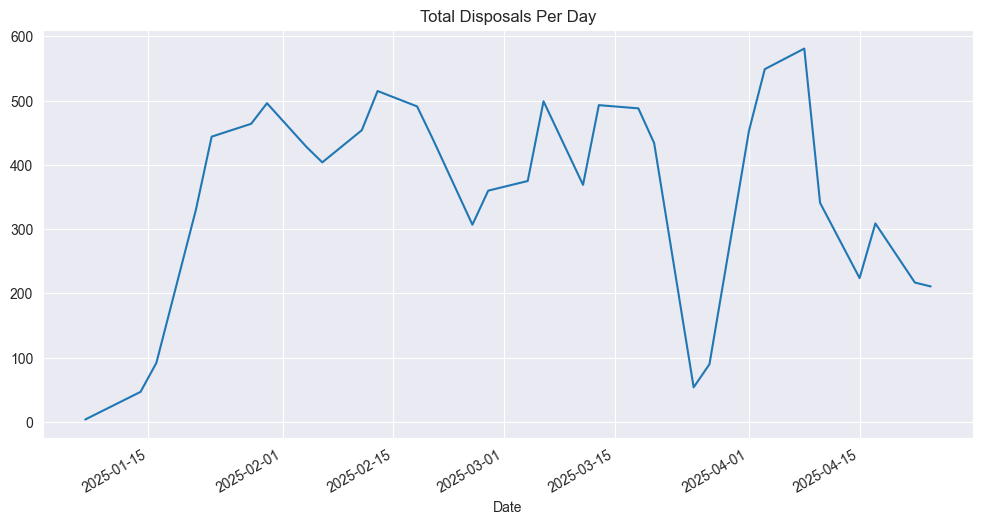

In [42]:
disposals['Date'] = pd.to_datetime(disposals['Date'])

total_disposals_per_day = disposals.groupby('Date')['Disposals'].sum()
total_disposals_per_day.plot(kind='line', figsize=(12, 6), title='Total Disposals Per Day')

### Contaminants Over Time
* Note: any time contaminations are mentioned in this notebook, it refers to the number/ percentage of items that were placed in the wrong bin. It accounts for garbage placed in recycling bins and recycling placed in garbage bins.

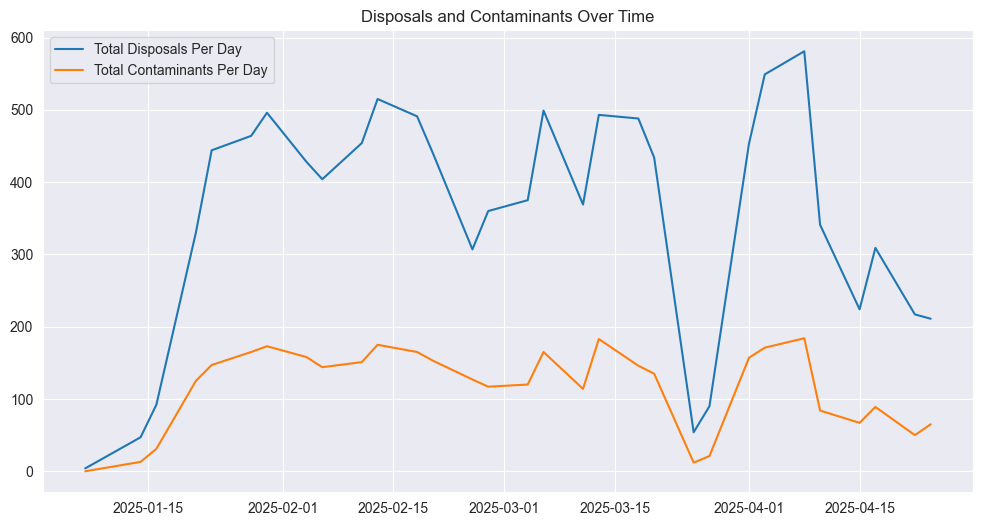

In [43]:
plt.figure(figsize=(12, 6))
total_contaminants_per_day = disposals.groupby('Date')['Contaminants'].sum()

plt.plot(total_disposals_per_day.index, total_disposals_per_day.values, label='Total Disposals Per Day')
plt.plot(total_contaminants_per_day.index, total_contaminants_per_day.values, label='Total Contaminants Per Day')
plt.title('Disposals and Contaminants Over Time')
plt.legend()
plt.show()

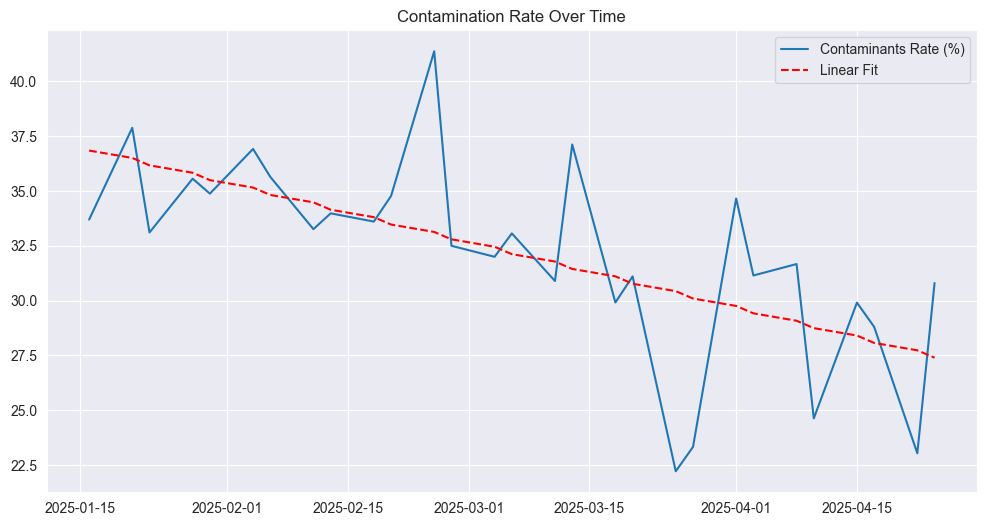

In [44]:
contamiination_rate_per_day = (total_contaminants_per_day / total_disposals_per_day) * 100

N = 2

x = np.arange(len(contamiination_rate_per_day))[N:]
y = contamiination_rate_per_day.values[N:]

slope, intercept = np.polyfit(x, y, 1)
trend = slope * x + intercept

plt.figure(figsize=(12, 6))
plt.plot(contamiination_rate_per_day.index[N:], y, label='Contaminants Rate (%)')
plt.plot(contamiination_rate_per_day.index[N:], trend, color='red', linestyle='--', label='Linear Fit')
plt.title('Contamination Rate Over Time')
plt.legend()
plt.show()

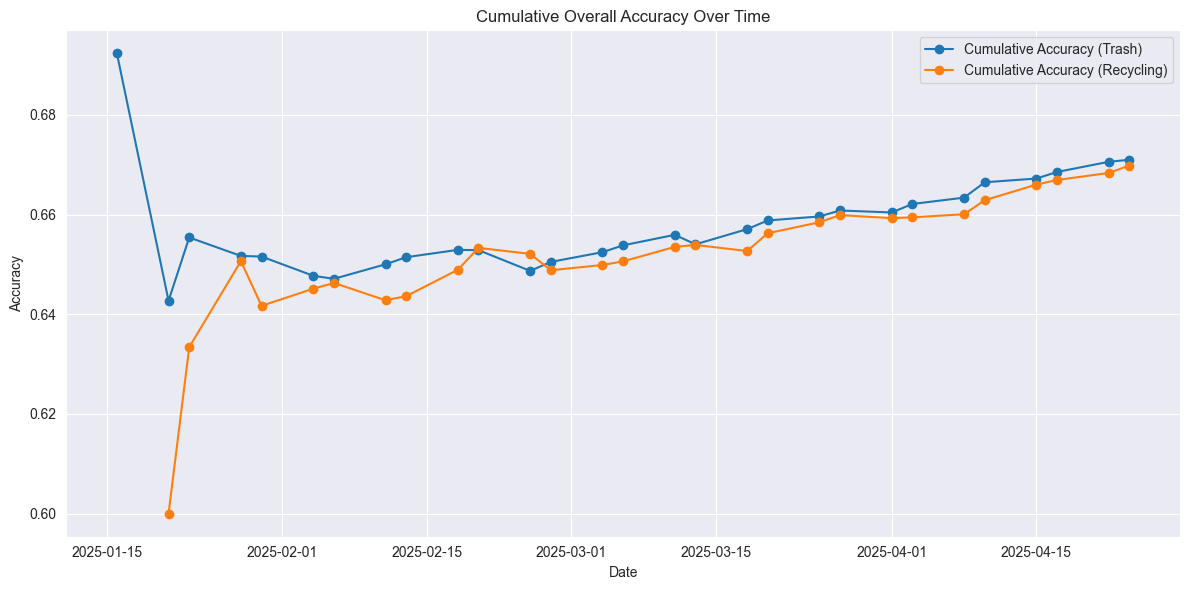

In [75]:
disposals['Date'] = pd.to_datetime(disposals['Date'])
disposals = disposals.sort_values('Date')

# Group by date and get daily sums
daily = disposals.groupby(['Date', 'Bin']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()

# Calculate cumulative sums
daily['Cumulative Disposals'] = daily['Disposals'].cumsum()
daily['Cumulative Contaminants'] = daily['Contaminants'].cumsum()

# Calculate cumulative accuracy
daily['Cumulative Accuracy'] = 1 - (daily['Cumulative Contaminants'] / daily['Cumulative Disposals'])

daily = daily[4:]

daily_garbage = daily[daily['Bin'] == 'Trash']
daily_recycling = daily[daily['Bin'] == 'Recycling']

plt.figure(figsize=(12, 6))
plt.plot(daily_garbage['Date'], daily_garbage['Cumulative Accuracy'], marker='o', label='Cumulative Accuracy (Trash)')
plt.plot(daily_recycling['Date'], daily_recycling['Cumulative Accuracy'], marker='o', label='Cumulative Accuracy (Recycling)')
plt.title('Cumulative Overall Accuracy Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

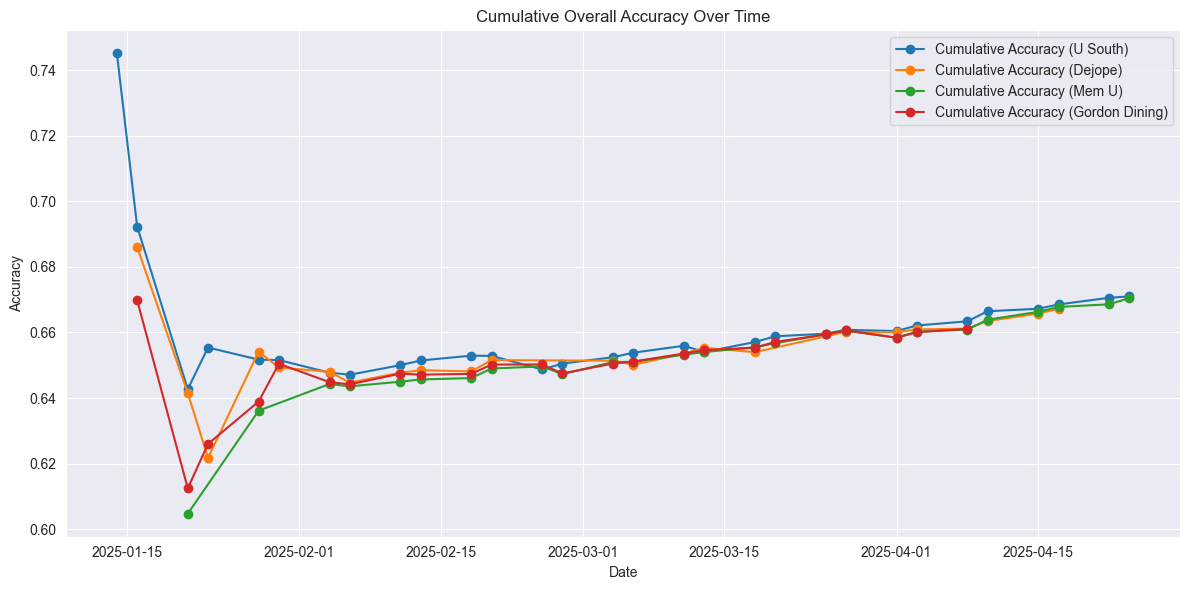

In [76]:
# Accuracy over time by location

disposals['Date'] = pd.to_datetime(disposals['Date'])
disposals = disposals.sort_values('Date')

# Group by date and get daily sums
daily = disposals.groupby(['Date', 'Device']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()

# Calculate cumulative sums
daily['Cumulative Disposals'] = daily['Disposals'].cumsum()
daily['Cumulative Contaminants'] = daily['Contaminants'].cumsum()

# Calculate cumulative accuracy
daily['Cumulative Accuracy'] = 1 - (daily['Cumulative Contaminants'] / daily['Cumulative Disposals'])

daily = daily[4:]

devices = disposals['Device'].unique()

plt.figure(figsize=(12, 6))

for device in devices:
    daily_device = daily[daily['Device'] == device]
    plt.plot(daily_device['Date'], daily_device['Cumulative Accuracy'], marker='o', label=f'Cumulative Accuracy ({device})')

plt.title('Cumulative Overall Accuracy Over Time')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Frequencies of Items Disposed

In [47]:
item_freqs = disposals.groupby(['Item', 'Correct Bin'])['Disposals'].sum().sort_values(ascending=False)
print(item_freqs.head(5))

Item               Correct Bin
napkin             Trash          2302
plastic cutlery    Trash          1201
plastic container  Recycling      1192
food box           Trash           756
wrapper            Trash           752
Name: Disposals, dtype: int64


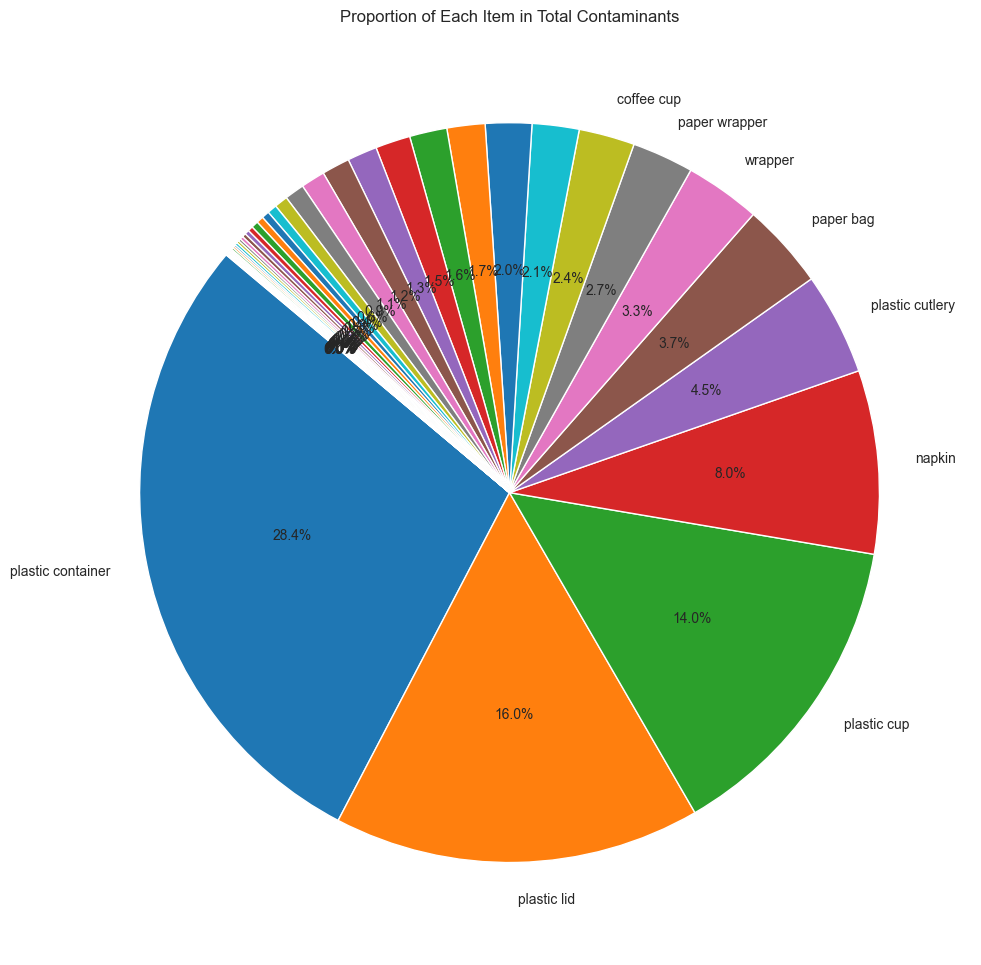

In [48]:
contaminants_by_item = disposals.groupby('Item')['Contaminants'].sum()
# Filter out items with zero contaminants (optional)
contaminants_by_item = contaminants_by_item[contaminants_by_item > 0]
contaminants_by_item = contaminants_by_item.sort_values(ascending=False)

labels = [item if value > 80 else '' for item, value in contaminants_by_item.items()]

# Plot pie chart
plt.figure(figsize=(10, 10))
plt.pie(contaminants_by_item, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Each Item in Total Contaminants')
plt.tight_layout()
plt.show()

Item               Correct Bin
plastic container  Recycling      1026
plastic lid        Recycling       578
plastic cup        Recycling       504
napkin             Trash           289
plastic cutlery    Trash           161
paper bag          Recycling       135
wrapper            Trash           119
paper wrapper      Recycling        97
coffee cup         Recycling        88
paper              Recycling        74
Name: Contaminants, dtype: int64


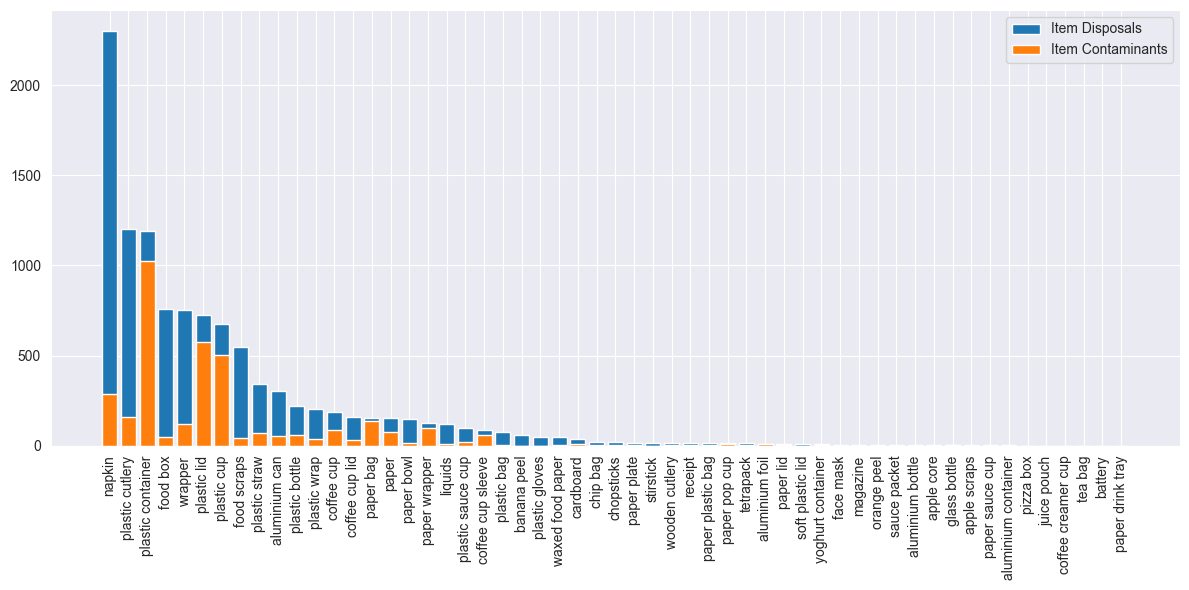

In [49]:
item_contaminant_freqs = disposals.groupby(['Item', 'Correct Bin'])['Contaminants'].sum().sort_values(ascending=False)
print(item_contaminant_freqs.head(10))

plt.figure(figsize=(12, 6))
x = np.arange(len(item_freqs.index))

plt.bar(x, item_freqs.values, label='Item Disposals')
plt.bar(x, item_contaminant_freqs.reindex(item_freqs.index, fill_value=0).values, label='Item Contaminants')

plt.xticks(x, item_freqs.index.get_level_values('Item'), rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

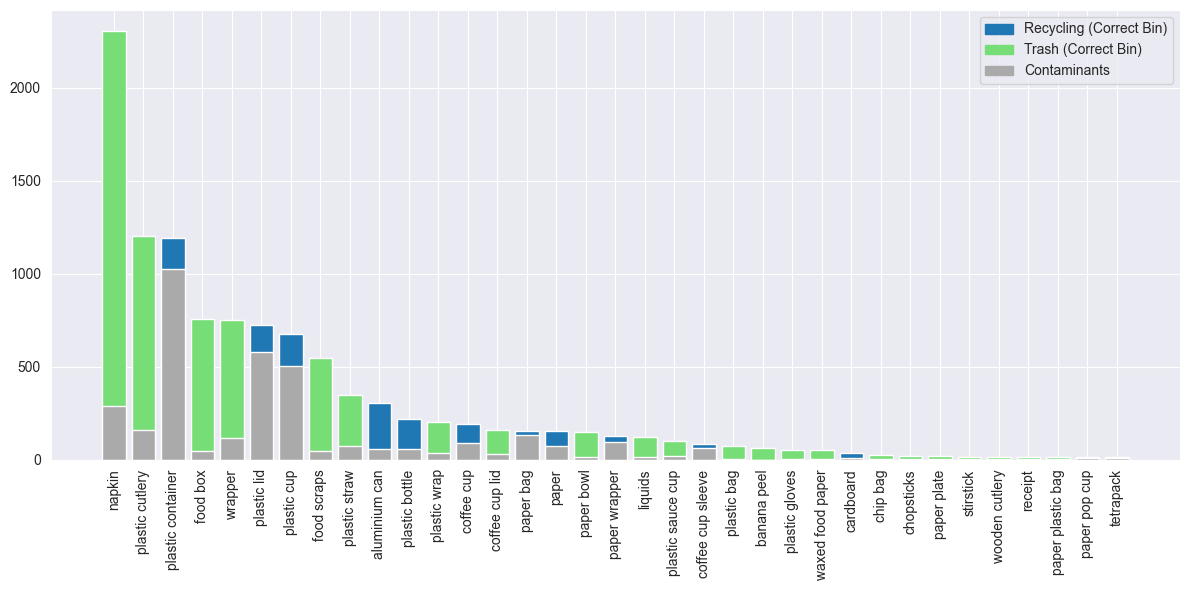

In [50]:
import numpy as np
from matplotlib.patches import Patch

cut_item_freqs = item_freqs.iloc[:-20]

bin_colors = {'Recycling': '#1f77b4', 'Trash': '#77dd77'}
bar_colors = [bin_colors[bin_] for _, bin_ in cut_item_freqs.index]

contam_colors = {'Recycling': '#AAAAAA', 'Trash': '#AAAAAA'}
bar_contam_colors = [contam_colors[bin_] for _, bin_ in cut_item_freqs.index]

plt.figure(figsize=(12, 6))
x = np.arange(len(cut_item_freqs.index))

plt.bar(x, cut_item_freqs.values, color=bar_colors, label='Item Disposals')
plt.bar(x, item_contaminant_freqs.reindex(cut_item_freqs.index, fill_value=0).values,
        color=bar_contam_colors, label='Item Contaminants')

plt.xticks(x, cut_item_freqs.index.get_level_values('Item'), rotation=90)
legend_handles = [
    Patch(color=bin_colors['Recycling'], label='Recycling (Correct Bin)'),
    Patch(color=bin_colors['Trash'], label='Trash (Correct Bin)'),
    Patch(color=contam_colors['Recycling'], label='Contaminants'),
]
plt.legend(handles=legend_handles)
plt.tight_layout()
plt.show()

Item               Correct Bin
paper drink tray   Recycling      100.000000
glass bottle       Recycling      100.000000
aluminium foil     Recycling       91.666667
paper bag          Recycling       87.662338
plastic container  Recycling       86.073826
dtype: float64


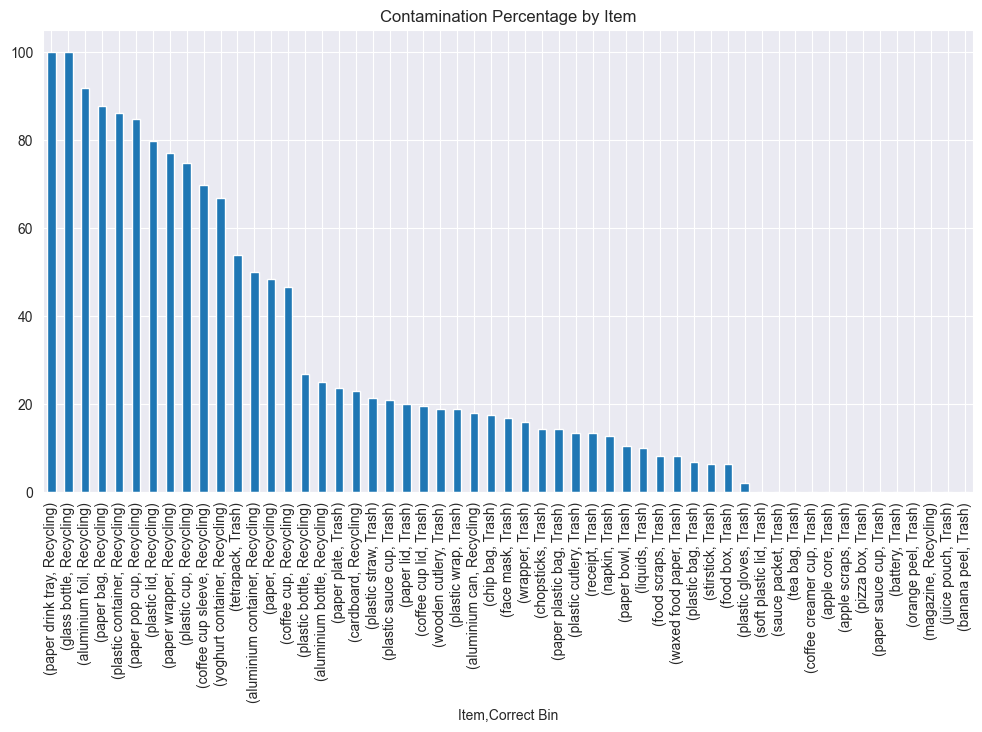

In [51]:
contamination_percentage = (item_contaminant_freqs / item_freqs * 100).sort_values(ascending=False)
contamination_percentage.plot(kind='bar', figsize=(12, 6), title='Contamination Percentage by Item')
print(contamination_percentage.head(5))

### Disposals by Device

Item               Correct Bin
napkin             Trash          2302
plastic cutlery    Trash          1201
plastic container  Recycling      1192
food box           Trash           756
Name: Disposals, dtype: int64


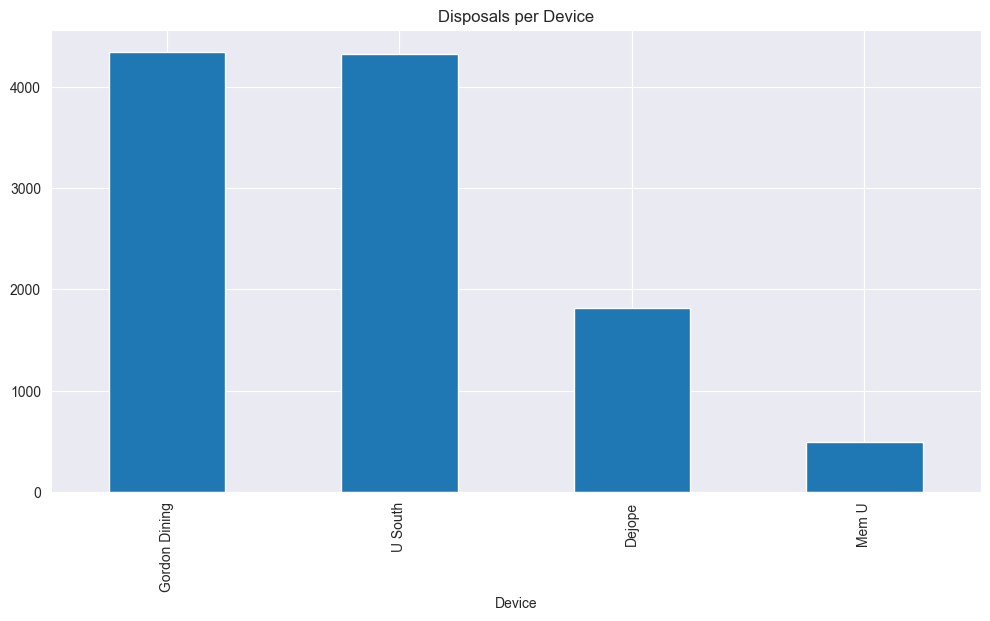

In [52]:
disposals_by_device = disposals.groupby('Device')['Disposals'].sum().sort_values(ascending=False)
disposals_by_device.plot(kind='bar', figsize=(12, 6), title='Disposals per Device')
print(item_freqs.head(4))

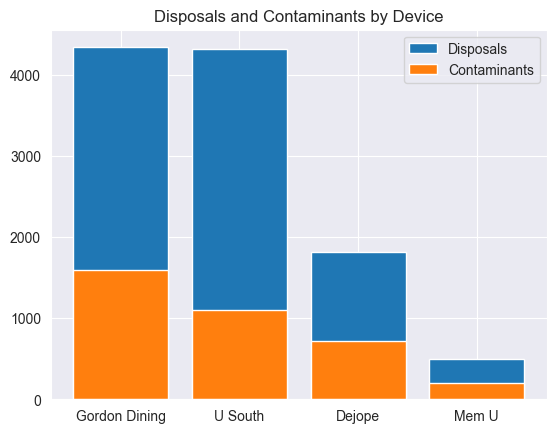

Device
Mem U            40.733198
Dejope           39.403974
Gordon Dining    36.587612
U South          25.573315
dtype: float64


In [53]:
contaminants_by_device = disposals.groupby('Device')['Contaminants'].sum().sort_values(ascending=False)

plt.bar(disposals_by_device.index, disposals_by_device.values, label='Disposals')
plt.bar(contaminants_by_device.index, contaminants_by_device.values, label='Contaminants')
plt.title('Disposals and Contaminants by Device')
plt.legend()
plt.show()

contamination_percentage_by_device = (contaminants_by_device / disposals_by_device * 100).sort_values(ascending=False)
print(contamination_percentage_by_device.head(4))

## Union South Waste Audit Data
Audit was performed in December 2024

In [54]:
audit = pd.read_csv('USouth_waste_audit.csv')
print(audit.head(5))

   Day       Type  Mass (lbs)  Total Recyclable (lbs)  \
0  Tue    Garbage      363.57                   16.50   
1  Wed    Garbage      257.53                   12.10   
2  Thu    Garbage       95.15                    4.30   
3  Tue  Recycling       55.98                   27.42   
4  Wed  Recycling       16.90                   11.50   

   Contamination Percentage  
0                      4.54  
1                      4.70  
2                      4.52  
3                     48.98  
4                     68.05  


In [55]:
# These numbers come directly from the waste audit report
total_usouth_recycle_contamination = 53.40
total_usouth_garbage_contamination = 4.59

In [56]:
usouth = disposals[disposals['Device'] == 'U South']

contamination_by_bin = (usouth.groupby('Bin')['Contaminants'].sum() / usouth.groupby('Bin')['Disposals'].sum()) * 100

contamination_percentages = pd.DataFrame({
    'Type': ['Recycling', 'Garbage', 'Recycling', 'Garbage'],
    'Source': ['Audit', 'Audit', 'Device', 'Device'],
    'Percentage': [53.40, 4.59, contamination_by_bin['Recycling'], contamination_by_bin['Trash']]

})

print(contamination_percentages.head())

        Type  Source  Percentage
0  Recycling   Audit   53.400000
1    Garbage   Audit    4.590000
2  Recycling  Device   41.597139
3    Garbage  Device   21.707878


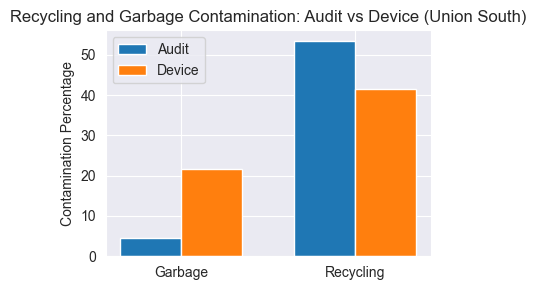

In [57]:
pivot_df = contamination_percentages.pivot(index='Type', columns='Source', values='Percentage')

# Set up bar positions
types = pivot_df.index
x = np.arange(len(types))
width = 0.35

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(x - width/2, pivot_df['Audit'], width, label='Audit')
ax.bar(x + width/2, pivot_df['Device'], width, label='Device')

ax.set_ylabel('Contamination Percentage')
ax.set_title('Recycling and Garbage Contamination: Audit vs Device (Union South)')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend()
plt.tight_layout()
plt.show()

## Item by Item Analysis

### Linearity of Item and Overall Contamination

In [58]:
# Get daily accuracy by item
item_daily = disposals.groupby(['Date', 'Item']).agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()
item_daily['Accuracy'] = 1 - (item_daily['Contaminants'] / item_daily['Disposals'])

# Get daily overall accuracy
daily = disposals.groupby('Date').agg({'Disposals': 'sum', 'Contaminants': 'sum'}).reset_index()
daily['Accuracy'] = 1 - (daily['Contaminants'] / daily['Disposals'])

# Compute correlations between item accuracy and overall accuracy
for item in item_daily['Item'].unique():
    item_data = item_daily[item_daily['Item'] == item]
    # left join item data and daily on item
    item_data = item_data.merge(daily[['Date', 'Accuracy']], on='Date', suffixes=('', '_Overall'))
    if len(item_data) >= 2 and len(item_data['Accuracy'].unique()) > 1:
        # Calculate Pearson correlation coefficient
        correlation, _ = pearsonr(item_data['Accuracy'], item_data['Accuracy_Overall'])
        print(f'Correlation between {item} accuracy and overall accuracy: {correlation:.2f}')

        item_daily.loc[item_daily['Item'] == item, 'Correlation'] = correlation
    else:
        print(f'Not enough data for {item} to calculate correlation.')
        item_daily.loc[item_daily['Item'] == item, 'Correlation'] = 0


Not enough data for apple core to calculate correlation.
Correlation between plastic gloves accuracy and overall accuracy: 0.06
Correlation between plastic wrap accuracy and overall accuracy: 0.40
Correlation between coffee cup accuracy and overall accuracy: 0.34
Correlation between coffee cup lid accuracy and overall accuracy: 0.02
Correlation between coffee cup sleeve accuracy and overall accuracy: 0.14
Correlation between food box accuracy and overall accuracy: -0.33
Correlation between napkin accuracy and overall accuracy: 0.07
Correlation between plastic bag accuracy and overall accuracy: -0.26
Correlation between plastic bottle accuracy and overall accuracy: 0.11
Correlation between plastic container accuracy and overall accuracy: 0.13
Correlation between plastic cup accuracy and overall accuracy: 0.50
Correlation between plastic cutlery accuracy and overall accuracy: -0.12
Correlation between plastic lid accuracy and overall accuracy: 0.59
Correlation between plastic sauce cup a

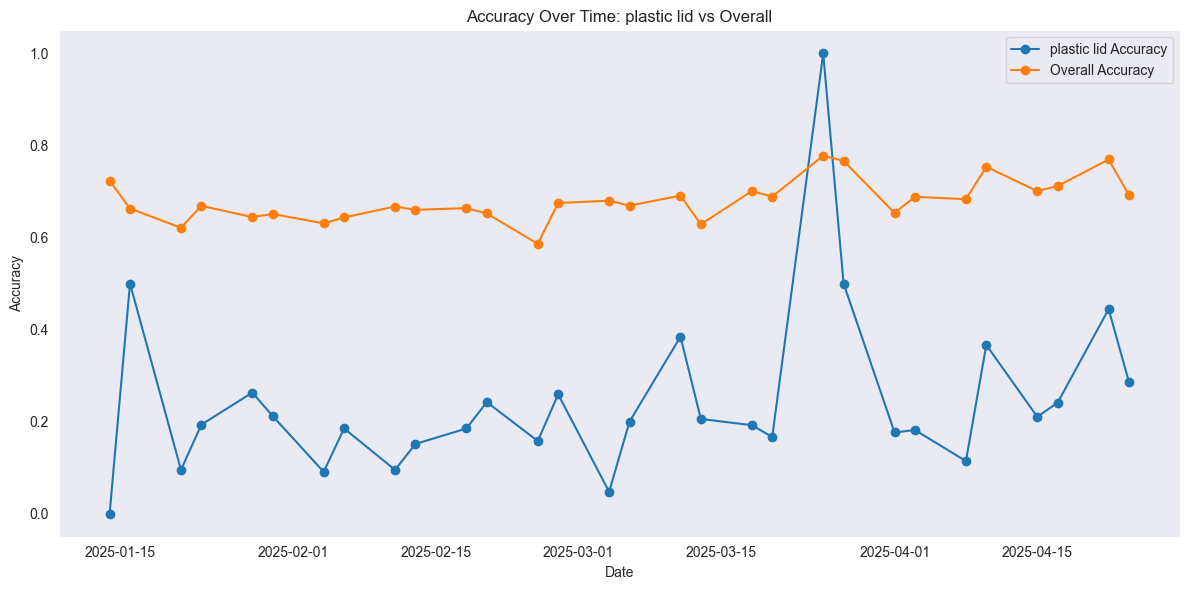

In [59]:
item = 'plastic lid'


item_data = item_daily[item_daily['Item'] == item]
item_data = item_data.merge(daily[['Date', 'Accuracy']], on='Date', suffixes=('', '_Overall'))

plt.figure(figsize=(12, 6))
plt.plot(item_data['Date'], item_data['Accuracy'], label=f'{item} Accuracy', marker='o')
plt.plot(item_data['Date'], item_data['Accuracy_Overall'], label='Overall Accuracy', marker='o')
plt.title(f'Accuracy Over Time: {item} vs Overall')
plt.xlabel('Date')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

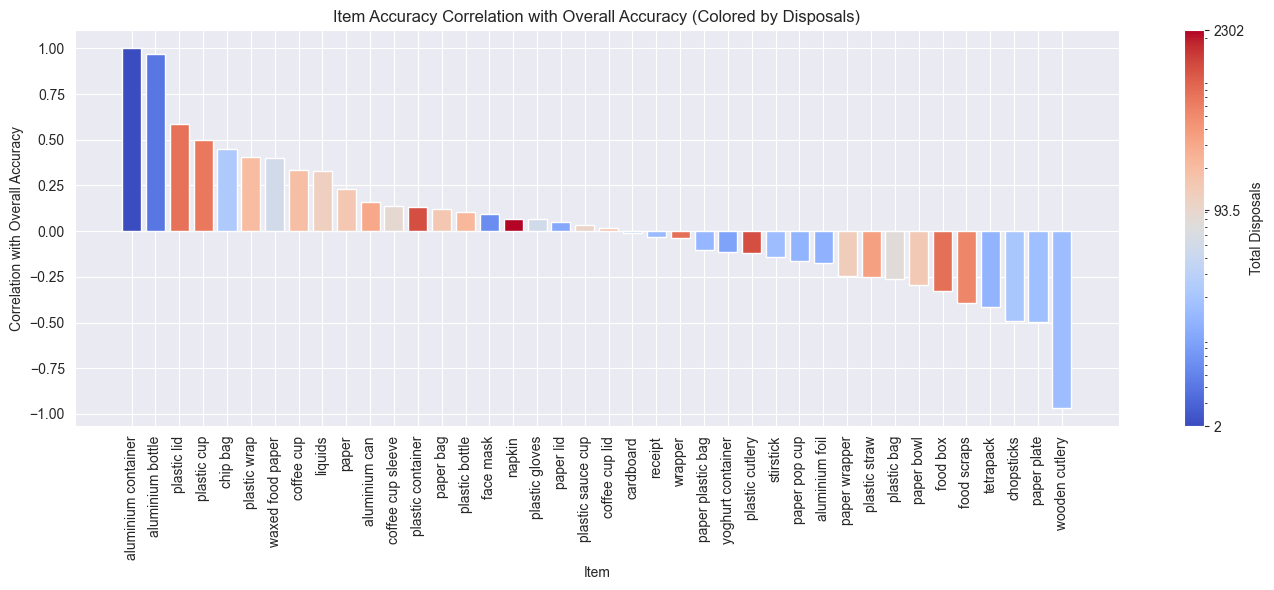

In [60]:
summary = item_daily.groupby('Item').agg({
    'Correlation': 'first',
    'Disposals': 'sum'
}).reset_index()

# Drop rows where correlation is 0 or NaN
summary = summary[(summary['Correlation'] != 0) & (~summary['Correlation'].isna())]

# Sort by correlation
summary = summary.sort_values('Correlation', ascending=False)

# Normalize disposals for colormap
norm = LogNorm(vmin=summary['Disposals'].min(), vmax=summary['Disposals'].max())
cmap = plt.cm.coolwarm
colors = cmap(norm(summary['Disposals']))


fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(summary['Item'], summary['Correlation'], color=colors)
ax.set_xticks(range(len(summary['Item'])))
ax.set_xticklabels(summary['Item'], rotation=90)
ax.set_xlabel('Item')
ax.set_ylabel('Correlation with Overall Accuracy')
ax.set_title('Item Accuracy Correlation with Overall Accuracy (Colored by Disposals)')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, label='Total Disposals', ax=ax)
cbar.set_ticks([summary['Disposals'].min(), summary['Disposals'].median(), summary['Disposals'].max()])
cbar.set_ticklabels([summary['Disposals'].min(), summary['Disposals'].median(), summary['Disposals'].max()])

plt.tight_layout()
plt.show()

## Disposal Confusion Matrix

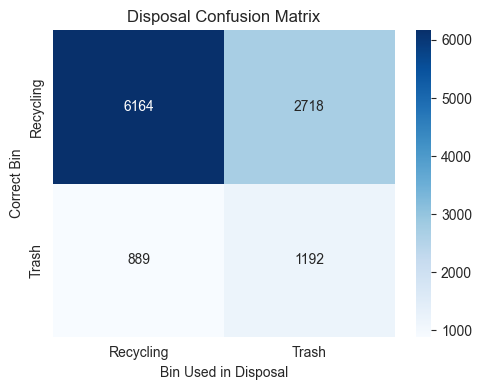

In [61]:
true_garbage = disposals[(disposals['Correct Bin'] == 'Trash') & (disposals['Contaminants'] == 0)]['Disposals'].sum()
false_garbage = disposals[(disposals['Correct Bin'] == 'Trash') & (disposals['Contaminants'] > 0)]['Disposals'].sum()
true_recycling = disposals[(disposals['Correct Bin'] == 'Recycling') & (disposals['Contaminants'] == 0)]['Disposals'].sum()
false_recycling = disposals[(disposals['Correct Bin'] == 'Recycling') & (disposals['Contaminants'] > 0)]['Disposals'].sum()

confusion_matrix = np.array([[true_garbage, false_recycling],[false_garbage, true_recycling]])
conf_df = pd.DataFrame(confusion_matrix, index=['Recycling', 'Trash'], columns=['Recycling', 'Trash'])

plt.figure(figsize=(5, 4))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Disposal Confusion Matrix')
plt.ylabel('Correct Bin')
plt.xlabel('Bin Used in Disposal')
plt.tight_layout()
plt.show()